## TODO
1. Проверить sound banks не на линухе, м.б. экспортнуть сразу в гитарпро на винде, т.к. на линухе все играет стандартное пианино.
2. Если экспортировать в drum не получится - перевести все ноты в набор основных звуков: кик, снейр, хэт, крэш и т.д., то, что есть в music21
3. Val loss всегда растет независимо от архитектуры. М.б. стоит избавиться от пауз, которые составляют 40 % партий и добавить конкатенацию с массивом длительностей
4. Или просто добавить больше партий?

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import guitarpro

import matplotlib.pyplot as plt

from src.model import NotesRNN
from src.parse_gp import drop_rests_from_drum_track, get_notes_and_durations
from src.save_midi import save_notes_and_durations, save_notes

Изначально было интересно проверить возможность генерации барабанных дорожек в своем стиле. Поэтому в коде отражены особенности написания барабанных партий именно мной.

А именно: простой бит в 4/4 |36 38 36 38| (36 - бочка, 38 - рабочий) можно описать 4-я нотами и 4-я длительностями в 1/4. 

Я же написал бы тот же такт таким образом: |36 R R R 38 R R R 36 R R R 38 R R R|, где R - просто пауза и все длительности 1/16. Поэтому после парсинга ударных в списке нот до 40% пауз, которые могли усложнить модель (по факту нет).

Поэтому по мере роста гипотез добавились функции дропа этих пауз и парсинга оригинальных длительностей, так что теперь можно применять код для парсинга любой дорожки и использовать модель с конкатенацией как нот, так и длительностей.

In [2]:
folderpath = "tabs/"
use_durations = True
drop_rests = False

In [3]:
notes, durations = [], []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        tab_notes, tab_durations = get_notes_and_durations(tab, False)
        notes += tab_notes
        durations += tab_durations

  0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
len(notes) == len(durations)

True

In [5]:
if drop_rests:
    notes, durations = drop_rests_from_drum_track(notes)

In [6]:
note_dictionary = {note: i for i, note in enumerate(set(notes))}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes]
notes_to_int[:10]

[109, 136, 149, 0, 72, 136, 149, 72, 0, 126]

In [7]:
notes[:10]

['del', '0.', '6.', '', '4.', '0.', '6.', '4.', '', '2.']

In [8]:
len(notes)

5421

In [9]:
len(note_dictionary)

175

In [10]:
if use_durations:
    duration_dictionary = {dur: i for i, dur in enumerate(set(durations))}
    inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
    durations_to_int = [duration_dictionary[dur] for dur in durations]
    durations_to_int[:10]
    print(len(duration_dictionary))
else:
    durations_to_int = None

6


In [12]:
n_notes = len(note_dictionary)
n_durations = len(duration_dictionary) if use_durations else None
emb_size = 100
n_units = 128
n_layers = 2
use_dropout = True
use_attention = True

In [13]:
RNN = NotesRNN(
    n_notes,
    n_durations,
    emb_size,
    n_units,
    n_layers,
    use_dropout,
    use_attention,
    use_durations
)

In [14]:
RNN.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    17500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    600         input_2[0][0]                    
______________________________________________________________________________________________

In [15]:
seq_length = 32
step = 1
X, y = RNN.prepare_sequences(notes_to_int, durations_to_int, seq_length, step)

In [16]:
RNN.model.fit(
    X, y,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/10
135/135 [==============================] - 7s 34ms/step - loss: 5.2143 - dense_1_loss: 3.9289 - dense_2_loss: 1.2854 - val_loss: 5.8871 - val_dense_1_loss: 4.5611 - val_dense_2_loss: 1.3261
Epoch 2/10
135/135 [==============================] - 4s 29ms/step - loss: 4.1952 - dense_1_loss: 3.1476 - dense_2_loss: 1.0477 - val_loss: 5.9974 - val_dense_1_loss: 4.6397 - val_dense_2_loss: 1.3576
Epoch 3/10
135/135 [==============================] - 4s 30ms/step - loss: 3.7847 - dense_1_loss: 2.8453 - dense_2_loss: 0.9393 - val_loss: 5.7966 - val_dense_1_loss: 4.5129 - val_dense_2_loss: 1.2838
Epoch 4/10
135/135 [==============================] - 4s 29ms/step - loss: 3.5077 - dense_1_loss: 2.6491 - dense_2_loss: 0.8585 - val_loss: 6.0719 - val_dense_1_loss: 4.6934 - val_dense_2_loss: 1.3785
Epoch 5/10
135/135 [==============================] - 4s 28ms/step - loss: 3.3499 - dense_1_loss: 2.5305 - dense_2_loss: 0.8193 - val_loss: 6.1709 - val_dense_1_loss: 4.7869 - val_dense_2_loss: 1.

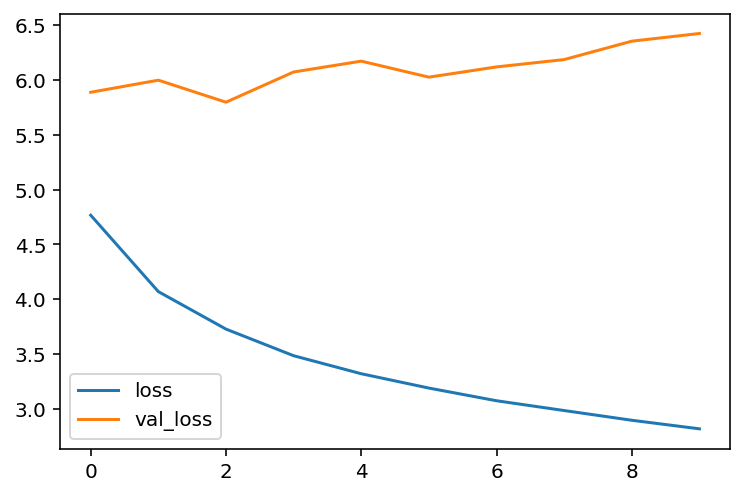

In [17]:
plt.figure()
plt.plot(RNN.model.history.history['loss'], label='loss')
plt.plot(RNN.model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [18]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [25]:
if use_durations:
    self_notes = [
        '46.36.', '46.36.', '46.38.', '46.36.', '38.', '46.36.', '38.', '46.36.', '46.38.', '46.36.', '38.',
        '46.36.', '46.36.', '46.38.', '46.36.', '38.', '46.36.', '38.', '46.36.', '46.38.', '46.36.', '38.',
    ]
    self_durations = [
        1/8, 1/8, 1/8, 1/16, 1/16, 1/16, 1/16, 1/8, 1/8, 1/16, 1/16,
        1/8, 1/8, 1/8, 1/16, 1/16, 1/16, 1/16, 1/8, 1/8, 1/16, 1/16
    ]
    generated_notes = [note_dictionary[x] for x in self_notes]
    generated_durations = [duration_dictionary[x] for x in self_durations]
    generated = [generated_notes, generated_durations]
else:
    self_notes = [
        '46.36.', '', '46.36.', '', '46.38.', '', '46.36.', '38.', '46.36.', '38.', '46.36.', '', '46.38.', '', '46.36.', '38.',
        '46.36.', '', '46.36.', '', '46.38.', '', '46.36.', '38.', '46.36.', '38.', '46.36.', '', '46.38.', '', '46.36.', '38.',
    ]
    generated = [note_dictionary[x] for x in self_notes]

In [23]:
generated = [[note_dictionary[x] for x in notes[:32]], [duration_dictionary[x] for x in durations[:32]]]

In [24]:
temperature = 0.5
n_generated = 100

att_matrix = np.zeros((n_generated+seq_length, n_generated))

for i in tqdm(range(n_generated)):
    if use_durations:
        note_pred, duration_pred = RNN.model.predict([np.array(generated[0][i:]), np.array(generated[1][i:])])
        generated[0].append(sample(note_pred[0], temperature))
        generated[1].append(sample(duration_pred[0], temperature))
    else:
        note_pred = RNN.model.predict([generated[i:]])
        generated.append(sample(note_pred[0], temperature))
#     if use_attention:
#         att_preds = RNN.att_model.predict(generated[i:])[0]
#         att_matrix[(i-len(att_preds)+seq_length):(i+seq_length), i] = att_preds

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
if use_durations:
    generated_to_notes = [inv_note_dictionary[i] for i in generated[0]]
    generated_to_durations = [inv_dur_dictionary[i] for i in generated[1]]
else:
    generated_to_notes = [inv_note_dictionary[i] for i in generated]
generated_to_notes[64:78]

['del',
 '12.12.',
 '3.3.3.',
 '7.5.',
 '1.0.0.',
 '0.',
 '4.4.',
 'del',
 '16.0.',
 '17.',
 '9.7.',
 '',
 '15.',
 '5.']

In [26]:
if use_durations:
    generated = [generated_to_notes, generated_to_durations]
else:
    generated = generated_to_notes

In [27]:
save_notes_and_durations(generated, 'output')
#save_notes(generated, 'output')

In [20]:
# if use_attention:
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = ax.imshow(att_matrix[(seq_length-2):,], cmap='coolwarm', interpolation='nearest')
#     ax.set_xticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.set_yticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
#     ax.set_xticks(np.arange(len(generated_to_notes) - seq_length))
#     ax.set_yticks(np.arange(len(generated_to_notes)- seq_length+2))
#     ax.set_xticklabels([n for n in generated_to_notes[(seq_length):]])
#     ax.set_yticklabels([n for n in generated_to_notes[(seq_length - 2):]])
#     ax.xaxis.tick_top()    
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
#              rotation_mode="anchor")

#     plt.show()